## Imports

In [6]:
# Standard library imports
import os
import random
import pickle
import imageio
from PIL import Image, ImageSequence

# Data analysis packages
import numpy as np
import pandas as pd
from scipy.signal import correlate, correlation_lags
from scipy.ndimage import gaussian_filter1d
from scipy.stats import norm

# Visualization packages
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyArrow, Patch, Circle
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D

# Braingeneers packages for analysis
import braingeneers
import braingeneers.data.datasets_electrophysiology as ephys
from braingeneers.analysis.analysis import SpikeData, read_phy_files, load_spike_data, burst_detection, randomize_raster

# Additional package
import diptest

# Custom package
from human_hip import spike_data

## Helper Functions

In [7]:
def local_safe_divide(numerator, denominator):
    """Safely divide two numbers, returning 0 when the denominator is 0."""
    return numerator / denominator if denominator != 0 else 0

def local_sttc_ta(tA, delt, tmax):
    '''
    Helper function for spike time tiling coefficients: calculate the
    total amount of time within a range delt of spikes within the
    given sorted list of spike times tA.
    '''
    if len(tA) == 0:
        return 0

    base = min(delt, tA[0]) + min(delt, tmax - tA[-1])
    return base + np.minimum(np.diff(tA), 2 * delt).sum()

def local_sttc_na(tA, tB, delt):
    '''
    Helper function for spike time tiling coefficients: given two
    sorted lists of spike times, calculate the number of spikes in
    spike train A within delt of any spike in spike train B.
    '''
    if len(tB) == 0:
        return 0
    tA, tB = np.asarray(tA), np.asarray(tB)

    # Find the closest spike in B after spikes in A.
    iB = np.searchsorted(tB, tA, side='right')
    iB = np.clip(iB, 1, len(tB) - 1)

    dt_left = np.abs(tB[iB - 1] - tA)
    dt_right = np.abs(tA - tB[np.clip(iB, 0, len(tB) - 1)])

    # Return how many of those spikes are actually within delt.
    return np.sum(np.minimum(dt_left, dt_right) <= delt)

def local_spike_time_tiling(tA, tB, TA, TB, delt):
    """
    Internal helper method for the second half of STTC calculation.
    """
    PA = local_safe_divide(local_sttc_na(tA, tB, delt), len(tA))
    PB = local_safe_divide(local_sttc_na(tB, tA, delt), len(tB))

    aa = local_safe_divide((PA - TB), (1 - PA * TB))
    bb = local_safe_divide((PB - TA), (1 - PB * TA))
    return (aa + bb) / 2

def local_spike_time_tiling_coefficient(tA, tB, delt=20, length=None):
    """
    Calculate the spike time tiling coefficient between two spike trains.
    """
    if length is None:
        length = max(tA[-1], tB[-1]) if tA and tB else 0

    if len(tA) == 0 or len(tB) == 0:
        return 0.0

    TA = local_safe_divide(local_sttc_ta(tA, delt, length), length)
    TB = local_safe_divide(local_sttc_ta(tB, delt, length), length)
    return local_spike_time_tiling(tA, tB, TA, TB, delt)

class LocalSpikeData:
    def __init__(self, train, length, neuron_data):
        self.train = train
        self.length = length
        self.N = len(train)
        self.neuron_data = neuron_data

    def local_spike_time_tilings(self, delt=20):
        """
        Compute the full spike time tiling coefficient matrix.
        """
        T = self.length
        ts = [local_safe_divide(local_sttc_ta(ts, delt, T), T) for ts in self.train]

        ret = np.diag(np.ones(self.N))
        for i in range(self.N):
            for j in range(i + 1, self.N):
                ret[i, j] = ret[j, i] = local_spike_time_tiling(
                    self.train[i], self.train[j], ts[i], ts[j], delt
                )
        return ret
    
def unpickle_object(filename):
    """
    Deserializes and returns an object from a file using the pickle protocol.

    Parameters:
    - filename: The name of the file from which the object will be loaded.

    Returns:
    - The Python object deserialized from the file.
    """
    with open(filename, 'rb') as file:
        obj = pickle.load(file)
    return obj

def position_to_grid(pos):
    return pos[0], pos[1]

def transform_neuron_data(sd):
    original_data = sd.neuron_data
    transformed_neuron_data = {'positions': {}}

    for top_level_key, clusters in original_data.items():
        for cluster_id, cluster_info in clusters.items():
            grid_pos = position_to_grid(cluster_info['position'])
            transformed_neuron_data['positions'][cluster_id] = {'position': grid_pos}

    return SpikeData(train=sd.train, length=sd.length, neuron_data=transformed_neuron_data)

## FCM Code

In [4]:
def latencies_between_two_neurons(train_a, train_b, window_ms=100):
    '''
    Compute latencies between the spike trains of two neurons.
    
    :param train_a: Spike train of the first neuron (numpy array).
    :param train_b: Spike train of the second neuron (numpy array).
    :param window_ms: Window in milliseconds to consider for latency calculation.
    :return: List of lists, where each sublist contains latencies from each spike in train_a
             to spikes in train_b within the specified window.
    '''
    latencies = []
    
    # Check if either of the trains is empty
    if len(train_a) == 0 or len(train_b) == 0:
        return latencies
    
    for spike_a in train_a:
        # Calculate differences between spike_a and all spikes in train_b
        diffs = train_b - spike_a
        # Filter the differences to find those within the specified window
        relevant_latencies = diffs[np.abs(diffs) <= window_ms]
        
        if len(relevant_latencies) > 0:
            latencies.append(relevant_latencies.tolist())
            
    return latencies

def analyze_spike_time_tilings(sd, delta_t, min_spikes, sttc_thresh, mean_thresh, pval_thresh, fwhm_thresh, local=False):
    dT = delta_t
    MIN_SPIKES = min_spikes
    N = sd.N
    STTC_THRESH = sttc_thresh
    MEAN_THRESH = mean_thresh
    PVAL_THRESH = pval_thresh
    FWHM_THRESH = fwhm_thresh

    tile_coefficients_whole = np.zeros((N, N))
    mean_latencies = np.nan * np.zeros((N, N))

    # Choose method based on the 'local' parameter
    if local:
        sttc_values = sd.local_spike_time_tilings(delt=dT)
    else:
        sttc_values = sd.spike_time_tilings(delt=dT)

    for ref_channel in range(N):
        for comp_channel in range(N):
            if ref_channel == comp_channel:
                continue
            ref_train = sd.train[ref_channel]
            comp_train = sd.train[comp_channel]
            
            # Ensure both channels have a minimum number of spikes
            if len(ref_train) > MIN_SPIKES and len(comp_train) > MIN_SPIKES:
                sttc_value = sttc_values[ref_channel, comp_channel]

                if sttc_value > STTC_THRESH:
                    latencies = latencies_between_two_neurons(ref_train, comp_train, window_ms=dT)

                    # Remove latencies larger than dT
                    latencies = [lat for sublist in latencies for lat in sublist if np.abs(lat) <= dT]

                    if np.abs(np.mean(latencies)) > 0:
                        pdf = np.sort(latencies)

                        # Compute the dip test
                        dip, p_val = diptest.diptest(pdf)

                        if p_val > PVAL_THRESH:
                            pd_mean = np.mean(pdf)
                            pd_std = np.std(pdf)
                            pd_fwhm = 2 * np.sqrt(2 * np.log(2)) * pd_std

                            if pd_fwhm < FWHM_THRESH:
                                mean_latencies[comp_channel, ref_channel] = pd_mean
                                # Adjust storage based on mean latency direction
                                if np.abs(mean_latencies[comp_channel, ref_channel]) > MEAN_THRESH:
                                    tile_coefficients_whole[comp_channel, ref_channel] = sttc_value

    return tile_coefficients_whole, mean_latencies

# Function to get neuron positions
def get_neuron_positions(spike_data):
    # Extract neuron positions from spike_data
    neuron_x = []
    neuron_y = []
    for neuron in spike_data.neuron_data['positions'].values():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])
    neuron_positions = np.array([neuron_x, neuron_y]).T
    return neuron_positions

def calculate_mean_firing_rates(spike_data):
    mean_firing_rates = []
    for neuron_spikes in spike_data.train:
        num_spikes = len(neuron_spikes)
        time_duration = spike_data.length / 1000  # Assuming spike times are in milliseconds
        firing_rate = num_spikes / time_duration
        mean_firing_rates.append(firing_rate)

    return np.array(mean_firing_rates)

def latencies_mean_neuron(lat_list):
    """
    Output: Returns a list containing the mean latencies for each sublist.
    Input: lat_list- A list of lists representing latencies between a particular neuron, x, and all others. Created with `sd.latencies_to_index(x)`
    """
    nested_list = lat_list
    for i in range(len(nested_list)):
        sublist = nested_list[i]
        length = len(sublist)
        if length == 0:
            sublist_mean = 0
        else:
            sublist_mean = sum(sublist)/len(sublist)
            sublist_mean = round(sublist_mean, 3) # Round to 3d.p.
        nested_list[i] = sublist_mean
    return nested_list

def latencies_mean_all(sd):
    """
    Output: Returns a list of lists containing the mean latencies between all neurons
    Input: sd- A SpikeData object, the standard data format for braingeneers
    """
    latencies_array = [None] * sd.N
    for curr_neuron in range(sd.N):
        latencies = latencies_mean_neuron(sd.latencies_to_index(curr_neuron))
        latencies_array[curr_neuron] = latencies # Store mean latency in corresponding position of 'latencies_array2'
    return latencies_array

def get_in_out_degree( mean_latency_matrix ): 
    """
    Output: Returns a list of tuples, [(incoming,outgoing),....] , containing the in and out degree for each neuron. 
            This is the number of "receicer" and "sender" signals the neurons get from other neurons
    Input: mean_latency_matrix- A list of lists containing the mean latency between all neurons
    """
    in_out_deg = [(0, 0) for _ in range(len(mean_latency_matrix))]
    for curr_neuron in range(len(mean_latency_matrix)):
        in_deg = 0
        out_deg = 0
        curr_neural_latencies = mean_latency_matrix[curr_neuron]
        for i in range(len(curr_neural_latencies)):
            if curr_neural_latencies[i] > 0:
                out_deg += 1
            if curr_neural_latencies[i] < 0:
                in_deg += 1
        in_out_deg[curr_neuron] = (in_deg, out_deg)
    return in_out_deg

def label_sender_receiver_neurons(in_out_deg, latency_thresh=0.2):
    node_info = ['grey'] * len(in_out_deg)
    for i in range(len(in_out_deg)):
        if (in_out_deg[i][1] + in_out_deg[i][0]) == 0:
            test1 = 0
            test2 = 0
        else:
            test1 = (in_out_deg[i][1] - in_out_deg[i][0]) / (in_out_deg[i][1] + in_out_deg[i][0])
            test2 = (in_out_deg[i][0] - in_out_deg[i][1]) / (in_out_deg[i][1] + in_out_deg[i][0])
        
        if test1 > latency_thresh:
            node_info[i] = 'red'
        elif test2 > latency_thresh:
            node_info[i] = 'blue'
    return node_info

## Network Computation

In [4]:
def compute_connectivity_data(sd, tile_coefficients_whole, latency_threshold=.1, compute_sttc=False):
    """
    Computes the necessary data for plotting the functional connectivity map.
    
    Args:
        sd (SpikeData object): The standard data format for braingeneers.
        latency_threshold (float): Threshold for fraction of in/out signals for "sender" or "receiver" labeling.
        sttc_threshold (float): Threshold for strength of spike time tiling correlation.
        compute_sttc (bool): If True, computes spike time tiling correlations.
        
    Returns:
        A dictionary containing precomputed data for plotting.
    """
    print("calculating all latencies...")
    all_mean_latencies = latencies_mean_all(sd)
    in_out_deg = get_in_out_degree(all_mean_latencies)
    sender_receiver_neurons = label_sender_receiver_neurons(in_out_deg, latency_threshold)
    
    data = {
        'sender_receiver_neurons': sender_receiver_neurons,
        'neuron_positions': sd.neuron_data['positions'],
    }
    
    if compute_sttc:
        print("calculating STTC...")
        sttc = tile_coefficients_whole
        data['sttc'] = sttc
    
    return data

## Plotter

In [5]:
def plot_functional_connectivity_map(precomputed_data, title, size, legends_loc, sttc_threshold=.1, show_sttc=True):
    """
    Plots the functional connectivity map using precomputed data.
    
    Args:
        precomputed_data (dict): Data computed by compute_connectivity_data.
        title (str): Title for the plot.
        sttc_threshold (float): Threshold for spike time tiling correlation plotting.
        show_sttc (bool): If True, plots spike time tiling connections.
    """
    print("making plot")
    neuron_x = []
    neuron_y = []
    for neuron in precomputed_data['neuron_positions'].values():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])
    plt.figure(figsize=(size[0], size[1]))
    plt.scatter(neuron_x, neuron_y, c=precomputed_data['sender_receiver_neurons'])
    
    # Plot legend for functional connectivity map
    node_type_legend_elements = [
        plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='grey', label='Broker'),
        plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='red', label='Sender'),
        plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='blue', label='Receiver')
    ]
    node_type_legend = plt.legend(handles=node_type_legend_elements, title='Node Type', loc=legends_loc[0])
    plt.gca().add_artist(node_type_legend)
    plt.title(title)
    plt.xlabel('X position')
    plt.ylabel('Y position')

    if show_sttc and 'sttc' in precomputed_data:
        sttc = precomputed_data['sttc']
        for i in range(sttc.shape[0]):
            for j in range(sttc.shape[1]):
                if i <= j: continue  # Skip duplicates and self-connections
                if sttc[i,j] < sttc_threshold: continue
                ix, iy = precomputed_data['neuron_positions'][i]['position']
                jx, jy = precomputed_data['neuron_positions'][j]['position']
                linewidth = 1.5 + 2 * (sttc[i, j] - sttc_threshold)
                opacity = 0.2 + 0.8 * (sttc[i, j] - sttc_threshold)  # Modify opacity based on correlation
                plt.plot([ix, jx], [iy, jy], linewidth=linewidth, c='grey', alpha=opacity)
        
        # Create legend for spike time tilings
        correlation_legend_elements = [
            plt.Line2D([0], [0], color='grey', linewidth=0.5, label='0.6'),
            plt.Line2D([0], [0], color='grey', linewidth=1.0, label='0.8'),
            plt.Line2D([0], [0], color='grey', linewidth=1.5, label='1.0')
        ]
        correlation_legend = plt.legend(handles=correlation_legend_elements, title='Correlation', loc=legends_loc[1])
        plt.gca().add_artist(correlation_legend)
    
    plt.gca().invert_yaxis()  # Invert y axis to match the image
    plt.axis('equal')  # Make x and y axis equal
    # Limit x and y axis
    plt.xlim(0, 1800)
    plt.ylim(600, 1500)
    #save with high res
    plt.savefig('fcm-' + title + '.png', dpi=300)
    # plt.savefig('fcm-' + title + '.png')
    plt.show()

In [6]:
def plot_functional_connectivity_map_rotated(precomputed_data, title, size, legends_loc, sttc_threshold=.1, show_sttc=True):
    """
    Plots the functional connectivity map using precomputed data, rotated 90 degrees clockwise.
    
    Args:
        precomputed_data (dict): Data computed by compute_connectivity_data.
        title (str): Title for the plot.
        sttc_threshold (float): Threshold for spike time tiling correlation plotting.
        show_sttc (bool): If True, plots spike time tiling connections.
    """
    print("making plot")
    neuron_x = []
    neuron_y = []
    for neuron in precomputed_data['neuron_positions'].values():
        # Swap x and y positions for rotation
        neuron_x.append(neuron['position'][1])  # Originally y
        neuron_y.append(neuron['position'][0])  # Originally x
    plt.figure(figsize=(size[1], size[0]))  # Swap size dimensions
    plt.scatter(neuron_x, neuron_y, c=precomputed_data['sender_receiver_neurons'])
    
    # Plot legend for functional connectivity map
    node_type_legend_elements = [
        plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='grey', label='Broker'),
        plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='red', label='Sender'),
        plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='blue', label='Receiver')
    ]
    node_type_legend = plt.legend(handles=node_type_legend_elements, title='Node Type', loc=legends_loc[0])
    plt.gca().add_artist(node_type_legend)
    plt.title(title)
    # Swap labels for x and y axis
    plt.xlabel('Y position')
    plt.ylabel('X position')

    if show_sttc and 'sttc' in precomputed_data:
        sttc = precomputed_data['sttc']
        for i in range(sttc.shape[0]):
            for j in range(sttc.shape[1]):
                if i <= j: continue  # Skip duplicates and self-connections
                if sttc[i,j] < sttc_threshold: continue
                # Swap positions for rotation
                ix, iy = precomputed_data['neuron_positions'][i]['position'][1], precomputed_data['neuron_positions'][i]['position'][0]
                jx, jy = precomputed_data['neuron_positions'][j]['position'][1], precomputed_data['neuron_positions'][j]['position'][0]
                linewidth = 1.5 + 2 * (sttc[i, j] - sttc_threshold)
                opacity = 0.2 + 0.8 * (sttc[i, j] - sttc_threshold)  # Modify opacity based on correlation
                plt.plot([ix, jx], [iy, jy], linewidth=linewidth, c='grey', alpha=opacity)
        
        # Create legend for spike time tilings
        correlation_legend_elements = [
            plt.Line2D([0], [0], color='grey', linewidth=0.5, label='0.6'),
            plt.Line2D([0], [0], color='grey', linewidth=1.0, label='0.8'),
            plt.Line2D([0], [0], color='grey', linewidth=1.5, label='1.0')
        ]
        correlation_legend = plt.legend(handles=correlation_legend_elements, title='Correlation', loc=legends_loc[1])
        plt.gca().add_artist(correlation_legend)
    
    plt.gca().invert_xaxis()  # Invert x axis to achieve 90-degree clockwise rotation effect
    plt.axis('equal')  # Make x and y axis equal
    # Save with high resolution
    plt.savefig('fcm-rotated-' + title + '.png', dpi=300)
    plt.show()

## Data

In [8]:
hc_328 = read_phy_files('/workspaces/human_hippocampus/data/ephys/2023-04-02-e-hc328_unperturbed/derived/kilosort2/hc3.28_hckcr1_chip16835_plated34.2_rec4.2_curated_s1.zip')
hc_52 = read_phy_files('/workspaces/human_hippocampus/data/ephys/2023-05-10-e-hc52_18790_unperturbed/derived/kilosort2/hc5.2_chip18790_baseline_rec5.10.23_curated_s1.zip')
hc_111 = read_phy_files('/workspaces/human_hippocampus/data/ephys/2022-11-02-e-Hc11.1-chip16753/derived/kilosort2/hc11.1_plated-11.1_chip-16753_rec_11.2.22AM-immediate_curated.zip')
hc_112823 = spike_data.read_autocurated_data('/workspaces/human_hippocampus/data/ephys/2023-12-03-e-Hc112823_avv9hckcr1/derived/kilosort2/Hc112723_hckcr1_21841_120323_base_acqm.zip')
hc_112823_2 = spike_data.read_autocurated_data('/workspaces/human_hippocampus/data/ephys/2023-12-03-e-Hc112823_avv9hckcr1/derived/kilosort2/Hc112723_hckcr1_21841_120323_base2_acqm.zip')
hc_120523_chip21769 = read_phy_files("/workspaces/human_hippocampus/data/ephys/2023-12-11-e-Hc120523_aav9hckcr1_chip21769/elliott/elliott_chip21769_base.zip")

hc_328 = transform_neuron_data(hc_328)
hc_52 = transform_neuron_data(hc_52)
hc_111 = transform_neuron_data(hc_111)
hc_112823 = transform_neuron_data(hc_112823)
hc_112823_2 = transform_neuron_data(hc_112823_2)
hc_120523_chip21769 = transform_neuron_data(hc_120523_chip21769)

/tmp/ipykernel_15356/2987344494.py:1: DeprecationWarning: Call to deprecated function (or staticmethod) read_phy_files. (Prefer load_spike_data()) -- Deprecated since version 0.1.13.
  hc_328 = read_phy_files('/workspaces/human_hippocampus/data/ephys/2023-04-02-e-hc328_unperturbed/derived/kilosort2/hc3.28_hckcr1_chip16835_plated34.2_rec4.2_curated_s1.zip')
/tmp/ipykernel_15356/2987344494.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) read_phy_files. (Prefer load_spike_data()) -- Deprecated since version 0.1.13.
  hc_52 = read_phy_files('/workspaces/human_hippocampus/data/ephys/2023-05-10-e-hc52_18790_unperturbed/derived/kilosort2/hc5.2_chip18790_baseline_rec5.10.23_curated_s1.zip')
/tmp/ipykernel_15356/2987344494.py:3: DeprecationWarning: Call to deprecated function (or staticmethod) read_phy_files. (Prefer load_spike_data()) -- Deprecated since version 0.1.13.
  hc_111 = read_phy_files('/workspaces/human_hippocampus/data/ephys/2022-11-02-e-Hc11.1-chip16753/der

In [50]:
def overall_latency_stats(sd, delta_t, min_spikes):
    N = sd.N
    dT = delta_t
    MIN_SPIKES = min_spikes

    all_latencies = []  # Collect all latency values across the dataset

    for ref_channel in range(N):
        for comp_channel in range(N):
            if ref_channel == comp_channel:
                continue  # Skip self-comparisons

            ref_train = sd.train[ref_channel]
            comp_train = sd.train[comp_channel]

            if len(ref_train) > MIN_SPIKES and len(comp_train) > MIN_SPIKES:
                latencies = latencies_between_two_neurons(ref_train, comp_train, window_ms=dT)
                filtered_latencies = [lat for sublist in latencies for lat in sublist if np.abs(lat) <= dT]

                # Absolute value for magnitude of latencies
                all_latencies.extend([np.abs(lat) for lat in filtered_latencies])

    # Compute the overall mean and standard deviation of the latencies
    mean_latency = np.mean(all_latencies)
    std_latency = np.std(all_latencies)

    return mean_latency, std_latency

def precalculate_distances_angles(neuron_positions):
    # Vectorized calculation of distances
    diff = neuron_positions[:, np.newaxis, :] - neuron_positions[np.newaxis, :, :]
    distances = np.sqrt(np.sum(diff**2, axis=2))

    # Vectorized calculation of angles
    angles = np.arctan2(diff[..., 1], diff[..., 0]) % (2 * np.pi)

    return distances, angles

def calculate_isi_stats(sd):
    isis_raw = sd.interspike_intervals()
    isis = []

    # Collect all ISIs, applying a filter for those less than 100 ms
    for isi in isis_raw:
        isis.extend([i for i in isi if i < 100])

    if isis:
        mean_isi = np.mean(isis)
        std_isi = np.std(isis)
        return mean_isi, std_isi
    else:
        return None, None  # Or handle the case of no ISIs as needed
    
def calculate_sttc_stats(sd):
    sttc_values = []

    # Iterate over each neuron pair and compute the STTC
    for i in range(sd.N):
        for j in range(sd.N):
            if i != j:  # Typically, STTC is not calculated for a neuron with itself
                sttc_value = sd.spike_time_tiling(i, j)
                sttc_values.append(sttc_value)

    # Compute the mean and standard deviation of the STTC values
    if sttc_values:
        mean_sttc = np.mean(sttc_values)
        std_sttc = np.std(sttc_values)
        return mean_sttc, std_sttc
    else:
        return None, None  # Or handle the case of no STTC values as needed
    
def mean_median_isi(sd):
    """
    Calculate the mean of the median interspike intervals (ISIs) for each unit in the spike_data.

    :param spike_data: An object containing spike train data, which has a method interspike_intervals() returning a list of arrays of ISIs for each unit.
    :return: The mean of the median ISIs across all units or NaN if no valid ISIs are found.
    """
    isi_list = sd.interspike_intervals()

    # Calculate the median ISI for each unit, considering only ISIs less than 100
    median_isi_list = []
    for isi in isi_list:
        filtered_isi = [isi_val for isi_val in isi if isi_val < 100]
        if filtered_isi:  # Check if the filtered list is not empty
            median_isi_list.append(np.median(filtered_isi))

    # Calculate the mean of the median ISIs if the list is not empty
    if median_isi_list:
        mean_median_isi = np.mean(median_isi_list)
    else:
        mean_median_isi = np.NaN  # Assign NaN if no valid medians were calculated

    return mean_median_isi

def median_distance(neuron_positions):
    """
    Calculate the median distance between all pairs of neurons.

    :param neuron_positions: An array of shape (n_neurons, 2) containing the x and y coordinates of the neurons.
    :return: The median distance between all neuron pairs.
    """
    # Calculate the distances between all pairs of neurons
    distances, _ = precalculate_distances_angles(neuron_positions)

    # Use only the upper triangular part of the distance matrix, excluding the diagonal
    upper_tri_distances = distances[np.triu_indices(distances.shape[0], k=1)]

    # Calculate and return the median of these distances
    median_dist = np.median(upper_tri_distances)
    return median_dist

In [51]:
# store mean median isi and median distance in dataframe with dataset names as column
df = pd.DataFrame(columns=['mean_median_isi', 'median_distance'])

datasets = [hc_328, hc_52, hc_111, hc_112823, hc_112823_2, hc_120523_chip21769]
dataset_names = ['hc_328', 'hc_52', 'hc_111', 'hc_112823', 'hc_112823_2', 'hc_120523_chip21769']

for dataset, dataset_name in zip(datasets, dataset_names):
    mean_median_isi_val = mean_median_isi(dataset)
    neuron_positions = get_neuron_positions(dataset)
    median_distance_val = median_distance(neuron_positions)
    df.loc[dataset_name] = [mean_median_isi_val, median_distance_val]

df

/tmp/ipykernel_4331/3561779166.py:87: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in spike_data.neuron_data['positions'].values():
/tmp/ipykernel_4331/3561779166.py:87: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in spike_data.neuron_data['positions'].values():
/tmp/ipykernel_4331/3561779166.py:87: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in spike_data.neuron_data['positions'].values():
/tmp/ipykernel_4331/3561779166.py:87: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron i

,mean_median_isi,median_distance
hc_328,37.594444,560.273371
hc_52,50.511111,687.640895
hc_111,38.631176,586.706911
hc_112823,52.583929,409.664497
hc_112823_2,56.545265,409.664497
hc_120523_chip21769,43.385000,315.485737


In [41]:
# # Initialize a list to store data
# data = []

# # Iterate over the datasets
# datasets = [hc_328, hc_52, hc_111, hc_112823, hc_112823_2, hc_120523_chip21769]
# for dataset in datasets:
#     current_mean_median_isi = mean_median_isi(dataset)  # corrected function name call
#     neuron_positions = get_neuron_positions(dataset)
#     median_dist = median_distance(neuron_positions)

#     # Append the data for this dataset to the list
#     data.append({'Dataset': dataset, 'Mean Median ISI': current_mean_median_isi, 'Median Distance': median_dist})

# # Create a DataFrame from the collected data
# df = pd.DataFrame(data)

# df

/tmp/ipykernel_4331/3561779166.py:87: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in spike_data.neuron_data['positions'].values():


,Dataset,Mean Median ISI,Median Distance
0,<braingeneers.analysis.analysis.SpikeData obje...,599.225368,560.273371
1,<braingeneers.analysis.analysis.SpikeData obje...,1650.964000,687.640895
2,<braingeneers.analysis.analysis.SpikeData obje...,1531.327874,586.706911
3,<braingeneers.analysis.analysis.SpikeData obje...,681.231225,409.664497
4,<braingeneers.analysis.analysis.SpikeData obje...,1249.273504,409.664497
5,<braingeneers.analysis.analysis.SpikeData obje...,537.614706,315.485737


In [27]:
# # Create dataframe to store results for mean and std latency, isi and sttc, for datasets hc_328, hc_52, hc_111, hc_112823, hc_112823_2, hc_120523_chip21769
# datasets = [hc_328, hc_52, hc_111, hc_112823, hc_112823_2, hc_120523_chip21769]
# dataset_names = ['hc_328', 'hc_52', 'hc_111', 'hc_112823', 'hc_112823_2', 'hc_120523_chip21769']
# delta_t = 20
# min_spikes = 5

# results = pd.DataFrame(columns=['Dataset', 'Mean Latency', 'Std Latency', 'Mean ISI', 'Std ISI', 'Mean STTC', 'Std STTC'])

# for i, dataset in enumerate(datasets):
#     mean_latency, std_latency = overall_latency_stats(dataset, delta_t, min_spikes)
#     mean_isi, std_isi = calculate_isi_stats(dataset)
#     mean_sttc, std_sttc = calculate_sttc_stats(dataset)
#     results.loc[i] = [dataset_names[i], mean_latency, std_latency, mean_isi, std_isi, mean_sttc, std_sttc]

In [19]:
# results

,Dataset,Mean Latency,Std Latency,Mean ISI,Std ISI,Mean STTC,Std STTC
0,hc_328,9.794420,5.881308,41.088171,35.823604,0.019938,0.054193
1,hc_52,8.234565,6.372000,47.464942,28.251000,0.039559,0.109290
2,hc_111,9.458277,6.000974,47.104564,25.738553,0.014167,0.066241
3,hc_112823,9.987176,5.790965,48.985870,28.659038,0.009972,0.028908
4,hc_112823_2,9.969939,5.797135,46.960318,28.654026,0.003076,0.036148
5,hc_120523_chip21769,9.854030,5.830624,44.243406,30.535855,0.067770,0.112219


## HC-328

In [9]:
tile_coeffs, mean_latencies = analyze_spike_time_tilings(hc_328, delta_t=20, min_spikes=5, sttc_thresh=0.05, mean_thresh=2, pval_thresh=0.1, fwhm_thresh=30)
hc_328_data = compute_connectivity_data(hc_328, tile_coeffs, latency_threshold=0.2, compute_sttc=True)

calculating all latencies...
calculating STTC...


/tmp/ipykernel_4656/319543331.py:21: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  'neuron_positions': sd.neuron_data['positions'],


In [13]:
def compute_neuron_proportions(data):
    # Extract the list of neurons from the data
    neurons = data.get("sender_receiver_neurons", [])
    
    # Count occurrences of each color
    grey_count = neurons.count('grey')
    red_count = neurons.count('red')
    blue_count = neurons.count('blue')
    
    # Total number of elements
    total_neurons = len(neurons)
    
    # Avoid division by zero if the list is empty
    if total_neurons == 0:
        return {'grey': 0, 'red': 0, 'blue': 0}
    
    # Calculate proportions
    grey_proportion = grey_count / total_neurons
    red_proportion = red_count / total_neurons
    blue_proportion = blue_count / total_neurons
    
    return {'broker': grey_proportion*100, 'sender': red_proportion*100, 'receiver': blue_proportion*100}

compute_neuron_proportions(hc_328_data)

{'broker': 82.35294117647058,
 'sender': 11.76470588235294,
 'receiver': 5.88235294117647}

making plot


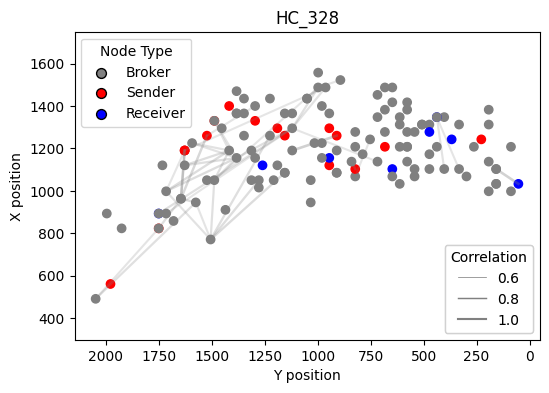

In [14]:
plot_functional_connectivity_map_rotated(hc_328_data, title='HC_328', size=(4, 6), legends_loc=['upper left', 'lower right'], sttc_threshold=0.1, show_sttc=True)

## HC-52

In [15]:
tile_coeffs, mean_latencies = analyze_spike_time_tilings(hc_52, delta_t=20, min_spikes=5, sttc_thresh=0.05, mean_thresh=2, pval_thresh=0.1, fwhm_thresh=30)
hc_52_data = compute_connectivity_data(hc_52, tile_coeffs, latency_threshold=.2, compute_sttc=True)

/srv/conda/envs/notebook/lib/python3.10/site-packages/diptest/diptest.py:168: UserWarning: Dip test is not valid for n <= 3
  warnings.warn("Dip test is not valid for n <= 3", stacklevel=1)


calculating all latencies...
calculating STTC...


/tmp/ipykernel_4656/319543331.py:21: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  'neuron_positions': sd.neuron_data['positions'],


making plot


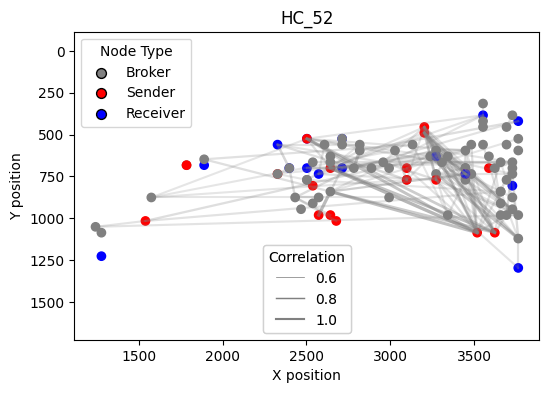

In [11]:
plot_functional_connectivity_map(hc_52_data, title='HC_52', size=(6,4), legends_loc=['upper left', 'lower center'], sttc_threshold=.1, show_sttc=True)

## HC-111

In [16]:
tile_coeffs, mean_latencies = analyze_spike_time_tilings(hc_111, delta_t=20, min_spikes=5, sttc_thresh=0.05, mean_thresh=2, pval_thresh=0.1, fwhm_thresh=30)
hc_111_data = compute_connectivity_data(hc_111, tile_coeffs, latency_threshold=.2, compute_sttc=True)

calculating all latencies...


KeyboardInterrupt: 

making plot


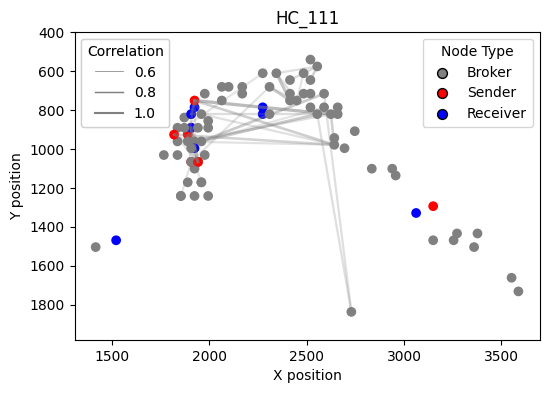

In [13]:
plot_functional_connectivity_map(hc_111_data, title='HC_111', size=(6,4), legends_loc=['upper right', 'upper left'], sttc_threshold=.1, show_sttc=True)

## HC-112823

In [ ]:
tile_coeffs, mean_latencies = analyze_spike_time_tilings(hc_112823, delta_t=20, min_spikes=5, sttc_thresh=0.05, mean_thresh=2, pval_thresh=0.1, fwhm_thresh=30)
hc_112823_data = compute_connectivity_data(hc_112823, tile_coeffs, latency_threshold=.2, compute_sttc=True)

calculating all latencies...
calculating STTC...


/tmp/ipykernel_18054/319543331.py:21: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  'neuron_positions': sd.neuron_data['positions'],


making plot


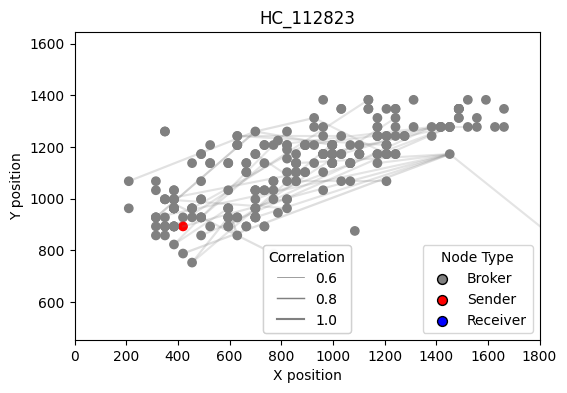

In [129]:
plot_functional_connectivity_map(hc_112823_data, title='HC_112823', size=(6, 4), legends_loc=['lower right', 'lower center'], sttc_threshold=.1, show_sttc=True)

## HC-112823-2

In [ ]:
tile_coeffs, mean_latencies = analyze_spike_time_tilings(hc_112823_2, delta_t=20, min_spikes=5, sttc_thresh=0.05, mean_thresh=2, pval_thresh=0.1, fwhm_thresh=30)
hc_112823_2_data = compute_connectivity_data(hc_112823_2, tile_coeffs, latency_threshold=.2, compute_sttc=True)

calculating all latencies...
calculating STTC...


/tmp/ipykernel_18054/319543331.py:21: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  'neuron_positions': sd.neuron_data['positions'],


making plot


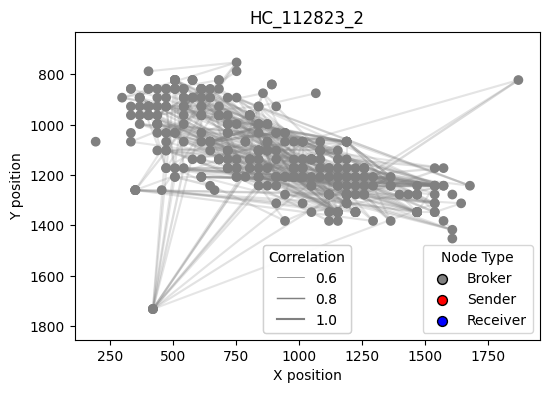

In [17]:
plot_functional_connectivity_map(hc_112823_2_data, title='HC_112823_2', size=(6,4), legends_loc=['lower right', 'lower center'], sttc_threshold=.1, show_sttc=True)

## HC-120523-chip21769

In [ ]:
tile_coeffs, mean_latencies = analyze_spike_time_tilings(hc_120523_chip21769, delta_t=20, min_spikes=5, sttc_thresh=0.05, mean_thresh=2, pval_thresh=0.1, fwhm_thresh=30)
hc_120523_chip21769_data = compute_connectivity_data(hc_120523_chip21769, tile_coeffs, latency_threshold=.2, compute_sttc=True)

calculating all latencies...
calculating STTC...


/tmp/ipykernel_18054/319543331.py:21: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  'neuron_positions': sd.neuron_data['positions'],


making plot


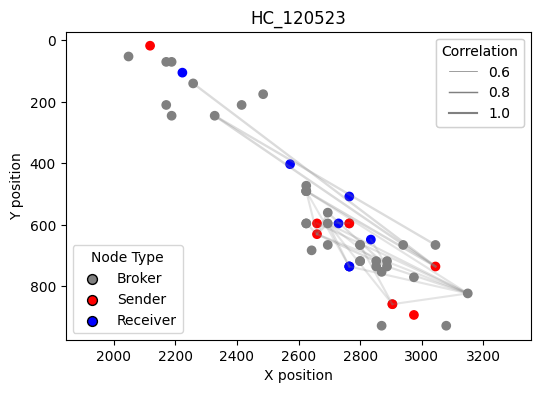

In [19]:
plot_functional_connectivity_map(hc_120523_chip21769_data, title='HC_120523', size=(6,4), legends_loc=['lower left', 'upper right'], sttc_threshold=.1, show_sttc=True)

In [130]:
# Pickle each of the datasets into a single dictionary

plotting_datasets = {
    'hc_328': hc_328_data,
    'hc_52': hc_52_data,
    'hc_111': hc_111_data,
    'hc_112823': hc_112823_data,
    'hc_112823_2': hc_112823_2_data,
    'hc_120523_chip21769': hc_120523_chip21769_data
}

with open('plotting_datasets.pkl', 'wb') as file:
    pickle.dump(plotting_datasets, file)

In [30]:
def combined_functional_connectivity_plots(data_info):
    """
    Creates a combined figure of functional connectivity maps, with adjustments based on user feedback.
    Legends are added only once, and subplot dimensions follow a 3:2 aspect ratio.

    Args:
        data_info (list): A list of tuples containing data and configuration for each plot.
                          Each tuple should have the format:
                          (data, title, size, legends_loc, sttc_threshold, show_sttc, is_rotated)
    """
    # Create the overall figure with a layout of 3x2 subplots
    # Adjust the figsize to control the size of the entire figure and try to maintain subplot aspect ratio
    fig, axs = plt.subplots(3, 2, figsize=(8, 8))  # This figsize might need tweaking
    
    for idx, (data, title, sttc_threshold, show_sttc, is_rotated) in enumerate(data_info):
        ax = axs[idx // 2, idx % 2]  # Determine the correct subplot location
        plt.sca(ax)  # Set the current axes to ax
        
        # Preparing neuron positions
        neuron_x = []
        neuron_y = []
        for neuron_id, neuron in data['neuron_positions'].items():
            if is_rotated:
                neuron_x.append(neuron['position'][1])  # Originally y
                neuron_y.append(neuron['position'][0])  # Originally x
            else:
                neuron_x.append(neuron['position'][0])
                neuron_y.append(neuron['position'][1])
        
        # Plotting neuron positions
        ax.scatter(neuron_x, neuron_y, c=data['sender_receiver_neurons'])

        # Plotting STTC connections if requested
        if show_sttc and 'sttc' in data:
            sttc = data['sttc']
            for i in range(sttc.shape[0]):
                for j in range(sttc.shape[1]):
                    if i <= j: continue  # Skip duplicates and self-connections
                    if sttc[i, j] < sttc_threshold: continue
                    if is_rotated:
                        ix, iy = data['neuron_positions'][i]['position'][1], data['neuron_positions'][i]['position'][0]
                        jx, jy = data['neuron_positions'][j]['position'][1], data['neuron_positions'][j]['position'][0]
                    else:
                        ix, iy = data['neuron_positions'][i]['position']
                        jx, jy = data['neuron_positions'][j]['position']
                    linewidth = 1.5 + 2 * (sttc[i, j] - sttc_threshold)
                    opacity = 0.2 + 0.8 * (sttc[i, j] - sttc_threshold)
                    ax.plot([ix, jx], [iy, jy], linewidth=linewidth, c='grey', alpha=opacity)

        # Setting title and axis labels
        ax.set_title(title)
        if is_rotated:
            ax.set_xlabel('Y position')
            ax.set_ylabel('X position')
            ax.invert_xaxis()  # For rotation effect
        else:
            ax.set_xlabel('X position')
            ax.set_ylabel('Y position')
            ax.invert_yaxis()  # To match the image as needed

        ax.axis('equal')

    # Adjust subplot parameters to give specified padding
    plt.tight_layout(pad=0.5)

    node_type_legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='grey', markeredgecolor='black', label='Broker', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markeredgecolor='black', label='Sender', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markeredgecolor='black', label='Receiver', markersize=10)
    ]

    correlation_legend_elements = [
        plt.Line2D([0], [0], color='grey', linewidth=0.5, label='0.6'),
        plt.Line2D([0], [0], color='grey', linewidth=1.0, label='0.8'),
        plt.Line2D([0], [0], color='grey', linewidth=1.5, label='1.0')
    ]

    # correlation_legend = ax.legend(handles=correlation_legend_elements, title='Correlation', loc=legends_loc[0])
    # node_type_legend = ax.legend(handles=node_type_legend_elements, title='Node Type', loc=legends_loc[0])

    # Optional: Add legends outside the subplots or in an empty subplot if you have one
    plt.figlegend(handles=node_type_legend_elements, loc='upper right', title='Node Type')
    plt.figlegend(handles=correlation_legend_elements, loc='upper left', title='Correlation')

    plt.savefig('combined_functional_connectivity_maps_adjusted.png', dpi=300)
    plt.show()

In [188]:
def combined_ca1_functional_connectivity_plots(data_info):
    """
    Creates a combined figure of functional connectivity maps, with adjustments based on user feedback.
    Legends are added only once, and subplot dimensions follow a 3:2 aspect ratio.

    Args:
        data_info (list): A list of tuples containing data and configuration for each plot.
                          Each tuple should have the format:
                          (data, title, size, legends_loc, sttc_threshold, show_sttc, is_rotated)
    """
    # Create the overall figure with a layout of 2x1 subplots
    # Adjust the figsize to control the size of the entire figure and try to maintain subplot aspect ratio
    fig, axs = plt.subplots(2, 1, figsize=(6,8))  # Adjusted for two subplots one on top of the other

    node_type_legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='grey', markeredgecolor='black', label='Broker', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markeredgecolor='black', label='Sender', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markeredgecolor='black', label='Receiver', markersize=10)
    ]

    correlation_legend_elements = [
        plt.Line2D([0], [0], color='grey', linewidth=0.5, label='Low STTC'),
        plt.Line2D([0], [0], color='grey', linewidth=1.0, label='Medium STTC'),
        plt.Line2D([0], [0], color='grey',linewidth=1.5, label='High STTC')
    ]
    
    for idx, (data, title, sttc_threshold, show_sttc, is_rotated) in enumerate(data_info):
        ax = axs[idx]  # Adjusted for a 2x1 subplot grid
        plt.sca(ax)  # Set the current axes to ax
    
        # Preparing neuron positions
        neuron_x = []
        neuron_y = []
        for neuron_id, neuron in data['neuron_positions'].items():
            if is_rotated:
                neuron_x.append(neuron['position'][1])  # Originally y
                neuron_y.append(neuron['position'][0])  # Originally x
            else:
                neuron_x.append(neuron['position'][0])
                neuron_y.append(neuron['position'][1])
        
        # Plotting neuron positions
        ax.scatter(neuron_x, neuron_y, c=data['sender_receiver_neurons'])

        # Plotting STTC connections if requested
        if show_sttc and 'sttc' in data:
            sttc = data['sttc']
            for i in range(sttc.shape[0]):
                for j in range(sttc.shape[1]):
                    if i <= j: continue  # Skip duplicates and self-connections
                    if sttc[i, j] < sttc_threshold: continue
                    if is_rotated:
                        ix, iy = data['neuron_positions'][i]['position'][1], data['neuron_positions'][i]['position'][0]
                        jx, jy = data['neuron_positions'][j]['position'][1], data['neuron_positions'][j]['position'][0]
                    else:
                        ix, iy = data['neuron_positions'][i]['position']
                        jx, jy = data['neuron_positions'][j]['position']
                    linewidth = 1.5 + 2 * (sttc[i, j] - sttc_threshold)
                    opacity = 0.2 + 0.8 * (sttc[i, j] - sttc_threshold)
                    ax.plot([ix, jx], [iy, jy], linewidth=linewidth, c='grey', alpha=opacity)

        # Setting title and axis labels
        ax.set_title(title)
        if is_rotated:
            ax.set_xlabel('Y position')
            ax.set_ylabel('X position')
            ax.invert_yaxis()
            # ax.invert_xaxis()  # For rotation effect
        else:
            ax.set_xlabel('X position')
            ax.set_ylabel('Y position')
            # ax.invert_yaxis()  # To match the image as needed

        ax.axis('equal')

    # Add two legends within one of the two subplots
    plt.figlegend(handles=node_type_legend_elements, loc='center right', title='Node Type')
    plt.figlegend(handles=correlation_legend_elements, loc='center left', title='Correlation')

    # Adjust subplot parameters to give specified padding
    plt.tight_layout(pad=0.5)
    
    # plt.figlegend(handles=node_type_legend_elements, loc='lower right', bbox_to_anchor=(1, 0.5), title='Node Type')
    # plt.figlegend(handles=correlation_legend_elements, loc='center left', bbox_to_anchor=(0, 0.5), title='Correlation')
    

    plt.savefig('combined_ca1_functional_connectivity_maps_adjusted.png', dpi=300)
    plt.show()


In [203]:
def combined_dg_functional_connectivity_plots(data_info):
    """
    Creates a combined figure of functional connectivity maps, with adjustments based on user feedback.
    Legends are added only once, and subplot dimensions follow a 3:2 aspect ratio.

    Args:
        data_info (list): A list of tuples containing data and configuration for each plot.
                          Each tuple should have the format:
                          (data, title, size, legends_loc, sttc_threshold, show_sttc, is_rotated)
    """
    # Create the overall figure with a layout of 3x2 subplots
    # Adjust the figsize to control the size of the entire figure and try to maintain subplot aspect ratio
    fig, axs = plt.subplots(2, 2, figsize=(8, 5))  # This figsize might need tweaking
    
    for idx, (data, title, sttc_threshold, x_spatial_window, y_spatial_window, show_sttc, is_rotated) in enumerate(data_info):
        ax = axs[idx // 2, idx % 2]  # Determine the correct subplot location
        plt.sca(ax)  # Set the current axes to ax

        # Preparing neuron positions
        neuron_x = []
        neuron_y = []
        for neuron_id, neuron in data['neuron_positions'].items():
            if is_rotated:
                neuron_x.append(neuron['position'][1])  # Originally y
                neuron_y.append(neuron['position'][0])  # Originally x
            else:
                neuron_x.append(neuron['position'][0])
                neuron_y.append(neuron['position'][1])
        
        # Plotting neuron positions
        ax.scatter(neuron_x, neuron_y, c=data['sender_receiver_neurons'], s=12)

        # Plotting STTC connections if requested
        if show_sttc and 'sttc' in data:
            sttc = data['sttc']
            for i in range(sttc.shape[0]):
                for j in range(sttc.shape[1]):
                    if i <= j: continue  # Skip duplicates and self-connections
                    if sttc[i, j] < sttc_threshold: continue
                    if is_rotated:
                        ix, iy = data['neuron_positions'][i]['position'][1], data['neuron_positions'][i]['position'][0]
                        jx, jy = data['neuron_positions'][j]['position'][1], data['neuron_positions'][j]['position'][0]
                    else:
                        ix, iy = data['neuron_positions'][i]['position']
                        jx, jy = data['neuron_positions'][j]['position']
                    linewidth = 1.5 + 2 * (sttc[i, j] - sttc_threshold)
                    opacity = 0.2 + 0.8 * (sttc[i, j] - sttc_threshold)
                    ax.plot([ix, jx], [iy, jy], linewidth=linewidth, c='grey', alpha=opacity)

        # Setting title and axis labels
        ax.set_title(title)
        if is_rotated:
            ax.set_xlabel('Y position')
            ax.set_ylabel('X position')
            ax.invert_xaxis()  # For rotation effect
        else:
            ax.set_xlabel('X position')
            ax.set_ylabel('Y position')
            ax.invert_yaxis()  # To match the image as needed

        ax.axis('equal')

        ax.set_xlim(x_spatial_window)
        ax.set_ylim(y_spatial_window)

    # Adjust subplot parameters to give specified padding
    plt.tight_layout(pad=0.5)

    node_type_legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='grey', markeredgecolor='black', label='Broker', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markeredgecolor='black', label='Sender', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markeredgecolor='black', label='Receiver', markersize=10)
    ]

    correlation_legend_elements = [
        plt.Line2D([0], [0], color='grey', linewidth=0.5, label='0.6'),
        plt.Line2D([0], [0], color='grey', linewidth=1.0, label='0.8'),
        plt.Line2D([0], [0], color='grey', linewidth=1.5, label='1.0')
    ]

    # correlation_legend = ax.legend(handles=correlation_legend_elements, title='Correlation', loc=legends_loc[0])
    # node_type_legend = ax.legend(handles=node_type_legend_elements, title='Node Type', loc=legends_loc[0])

    # Optional: Add legends outside the subplots or in an empty subplot if you have one
    plt.figlegend(handles=node_type_legend_elements, loc='center right', title='Node Type')
    plt.figlegend(handles=correlation_legend_elements, loc='center left', title='Correlation')

    plt.savefig('combined_dg_functional_connectivity_maps_adjusted.png', dpi=300)
    plt.show()

## Money Figure

In [20]:
def combined_full_functional_connectivity_plots(data_info):
    """
    Creates a combined figure of functional connectivity maps, with adjustments based on user feedback.
    Legends are added only once, and subplot dimensions follow a 3:2 aspect ratio.

    Args:
        data_info (list): A list of tuples containing data and configuration for each plot.
                          Each tuple should have the format:
                          (data, title, size, legends_loc, sttc_threshold, show_sttc, is_rotated)
    """
    # Create the overall figure with a layout of 3x2 subplots
    # Adjust the figsize to control the size of the entire figure and try to maintain subplot aspect ratio
    fig, axs = plt.subplots(3, 2, figsize=(8, 8))  # This figsize might need tweaking
    
    for idx, (data, title, sttc_threshold, x_spatial_window, y_spatial_window, show_sttc, is_rotated) in enumerate(data_info):
        ax = axs[idx // 2, idx % 2]  # Determine the correct subplot location
        plt.sca(ax)  # Set the current axes to ax

        # Preparing neuron positions
        neuron_x = []
        neuron_y = []
        for neuron_id, neuron in data['neuron_positions'].items():
            if is_rotated:
                neuron_x.append(neuron['position'][1])  # Originally y
                neuron_y.append(neuron['position'][0])  # Originally x
            else:
                neuron_x.append(neuron['position'][0])
                neuron_y.append(neuron['position'][1])
        
        # Plotting neuron positions
        ax.scatter(neuron_x, neuron_y, c=data['sender_receiver_neurons'], s=12)

        # Plotting STTC connections if requested
        if show_sttc and 'sttc' in data:
            sttc = data['sttc']
            for i in range(sttc.shape[0]):
                for j in range(sttc.shape[1]):
                    if i <= j: continue  # Skip duplicates and self-connections
                    if sttc[i, j] < sttc_threshold: continue
                    if is_rotated:
                        ix, iy = data['neuron_positions'][i]['position'][1], data['neuron_positions'][i]['position'][0]
                        jx, jy = data['neuron_positions'][j]['position'][1], data['neuron_positions'][j]['position'][0]
                    else:
                        ix, iy = data['neuron_positions'][i]['position']
                        jx, jy = data['neuron_positions'][j]['position']
                    linewidth = 1.5 + 2 * (sttc[i, j] - sttc_threshold)
                    opacity = 0.2 + 0.8 * (sttc[i, j] - sttc_threshold)
                    ax.plot([ix, jx], [iy, jy], linewidth=linewidth, c='grey', alpha=opacity)

        # Setting title and axis labels
        ax.set_title(title)
        if is_rotated:
            ax.set_xlabel('Y position')
            ax.set_ylabel('X position')
            ax.invert_xaxis()  # For rotation effect
        else:
            ax.set_xlabel('X position')
            ax.set_ylabel('Y position')
            ax.invert_yaxis()  # To match the image as needed

        ax.axis('equal')

        ax.set_xlim(x_spatial_window)
        ax.set_ylim(y_spatial_window)

    # Adjust subplot parameters to give specified padding
    plt.tight_layout(pad=0.5)

    # node_type_legend_elements = [
    #     plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='grey', markeredgecolor='black', label='Broker', markersize=10),
    #     plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markeredgecolor='black', label='Sender', markersize=10),
    #     plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markeredgecolor='black', label='Receiver', markersize=10)
    # ]

    # correlation_legend_elements = [
    #     plt.Line2D([0], [0], color='grey', linewidth=0.5, label='0.6'),
    #     plt.Line2D([0], [0], color='grey', linewidth=1.0, label='0.8'),
    #     plt.Line2D([0], [0], color='grey', linewidth=1.5, label='1.0')
    # ]

    node_type_legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='grey', markeredgecolor='black', label='Broker', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markeredgecolor='black', label='Sender', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markeredgecolor='black', label='Receiver', markersize=10)
    ]

    correlation_legend_elements = [
        plt.Line2D([0], [0], color='grey', linewidth=0.5, label='0.6'),
        plt.Line2D([0], [0], color='grey', linewidth=1.0, label='0.8'),
        plt.Line2D([0], [0], color='grey', linewidth=1.5, label='1.0')
    ]

    # Place the node type legend in the bottom left of the top left plot
    axs[1, 1].legend(handles=node_type_legend_elements, title='Node Type', loc='lower right')

    # Place the correlation legend in the top left of the right plot in the middle row
    axs[1, 0].legend(handles=correlation_legend_elements, title='Correlation', loc='lower right')

    # correlation_legend = ax.legend(handles=correlation_legend_elements, title='Correlation', loc=legends_loc[0])
    # node_type_legend = ax.legend(handles=node_type_legend_elements, title='Node Type', loc=legends_loc[0])

    # # Optional: Add legends outside the subplots or in an empty subplot if you have one
    # plt.figlegend(handles=node_type_legend_elements, loc='center right', title='Node Type')
    # plt.figlegend(handles=correlation_legend_elements, loc='center left', title='Correlation')

    plt.savefig('full_functional_connectivity_maps_figure.png', dpi=300)
    plt.show()

In [2]:
# Open plotting datasets
with open('plotting_datasets.pkl', 'rb') as file:
    plotting_datasets = pickle.load(file)

In [3]:
hc_328_data = plotting_datasets['hc_328']
hc_52_data = plotting_datasets['hc_52']
hc_111_data = plotting_datasets['hc_111']
hc_112823_data = plotting_datasets['hc_112823']
hc_112823_2_data = plotting_datasets['hc_112823_2']
hc_120523_chip21769_data = plotting_datasets['hc_120523_chip21769']

In [19]:
full_data_info = [
    (hc_328_data, 'HC_328', 0.1, (0, 2100), (250, 1750), True, True),
    (hc_52_data, 'HC_52', 0.1, (1200, 3800), (100, 1600), True, False),
    (hc_111_data, 'HC_111', 0.1, (1400, 3600), (400, 2000), True, False),
    (hc_120523_chip21769_data, 'HC_120523', 0.1, (2000, 3200), (0, 1000), True, False),
    (hc_112823_data, 'HC_112823', 0.1,(200, 1700), (700, 1400), True, False),
    (hc_112823_2_data, 'HC_112823_2', 0.1, (200, 2000), (600, 1900), True, False)
]

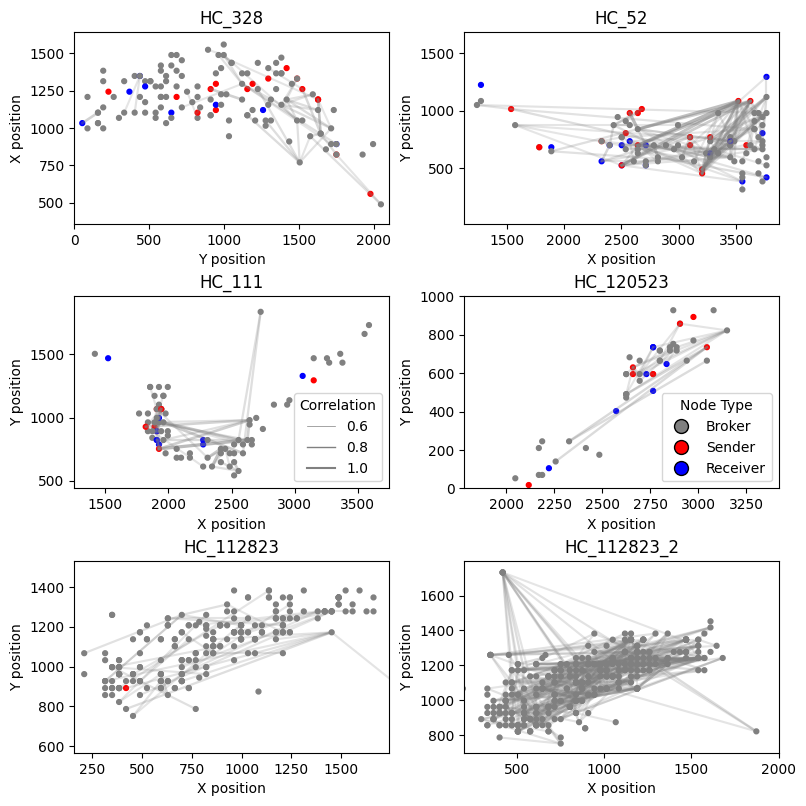

In [21]:
combined_full_functional_connectivity_plots(full_data_info)

In [4]:
def compute_neuron_proportions(data):
    # Extract the list of neurons from the data
    neurons = data.get("sender_receiver_neurons", [])
    
    # Count occurrences of each color
    grey_count = neurons.count('grey')
    red_count = neurons.count('red')
    blue_count = neurons.count('blue')
    
    # Total number of elements
    total_neurons = len(neurons)
    
    # Avoid division by zero if the list is empty
    if total_neurons == 0:
        return {'grey': 0, 'red': 0, 'blue': 0}
    
    # Calculate proportions
    grey_proportion = grey_count / total_neurons
    red_proportion = red_count / total_neurons
    blue_proportion = blue_count / total_neurons
    
    return {'broker': grey_proportion*100, 'sender': red_proportion*100, 'receiver': blue_proportion*100}

def compute_sttc_proportions(data):
    sttc = data.get('sttc', np.array([]))
    total_sttc_count = sttc.size
    nonzero_sttc_count = np.count_nonzero(sttc)
    
    # Avoid division by zero if the 'sttc' array is empty
    nonzero_sttc_proportion = nonzero_sttc_count / total_sttc_count if total_sttc_count else 0
    
    return {'nonzero_sttc': nonzero_sttc_proportion*100}

In [5]:
plotting_datasets = {
    'hc_328': hc_328_data,
    'hc_52': hc_52_data,
    'hc_111': hc_111_data,
    'hc_112823': hc_112823_data,
    'hc_112823_2': hc_112823_2_data,
    'hc_120523_chip21769': hc_120523_chip21769_data
}

# Compute the proportions for each dataset
results = {key: compute_neuron_proportions(value) for key, value in plotting_datasets.items()}

# Add the STTC proportions to the results
for key, value in plotting_datasets.items():
    results[key].update(compute_sttc_proportions(value))

# Create a pandas DataFrame from the results
proportions_df = pd.DataFrame(results).T  # Transpose to get datasets as rows and colors as columns

proportions_df

,broker,sender,receiver,nonzero_sttc
hc_328,82.352941,11.764706,5.882353,2.108564
hc_52,67.000000,18.000000,15.000000,9.540000
hc_111,81.609195,9.195402,9.195402,2.695204
hc_112823,99.598394,0.401606,0.000000,1.309656
hc_112823_2,100.000000,0.000000,0.000000,2.969132
hc_120523_chip21769,72.549020,13.725490,13.725490,5.536332


In [15]:
# add column percentage of non-broker neurons
proportions_df['non_broker'] = 100 - proportions_df['broker']

proportions_df

,broker,sender,receiver,nonzero_sttc,non_broker
hc_328,82.352941,11.764706,5.882353,2.108564,17.647059
hc_52,67.000000,18.000000,15.000000,9.540000,33.000000
hc_111,81.609195,9.195402,9.195402,2.695204,18.390805
hc_112823,99.598394,0.401606,0.000000,1.309656,0.401606
hc_112823_2,100.000000,0.000000,0.000000,2.969132,0.000000
hc_120523_chip21769,72.549020,13.725490,13.725490,5.536332,27.450980


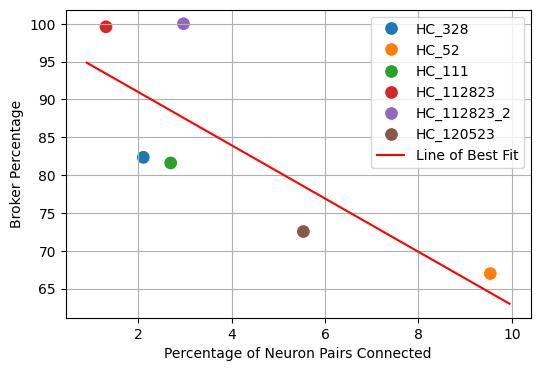

In [35]:
import seaborn as sns

# Sample data
data = {
    'broker_perc': [82.352941, 67.000000, 81.609195, 99.598394, 100.000000, 72.549020],
    'perc_neuron_pairs_connected': [2.108564, 9.540000, 2.695204, 1.309656, 2.969132, 5.536332],
    'dataset': ['HC_328', 'HC_52', 'HC_111', 'HC_112823', 'HC_112823_2', 'HC_120523']
}
proportions_df = pd.DataFrame(data)

# Plot setup
plt.figure(figsize=(6, 4))

# Scatter plot for individual points, using the 'dataset' column for hue
sns.scatterplot(data=proportions_df, x='perc_neuron_pairs_connected', y='broker_perc', hue='dataset', s=100)

# Get the current limits of the x-axis
x_start, x_end = plt.xlim()

# Calculate the slope and intercept for the line of best fit using the full range of x values
slope, intercept = np.polyfit(proportions_df['perc_neuron_pairs_connected'], proportions_df['broker_perc'], 1)

# Create the x-values for the line of best fit based on the x-axis limits
x_values = np.array([x_start, x_end])
y_values = slope * x_values + intercept

# Plot the line of best fit
plt.plot(x_values, y_values, label='Line of Best Fit', color='red')

# Enhancements
plt.ylabel('Broker Percentage')
plt.xlabel('Percentage of Neuron Pairs Connected')
plt.grid(True)
plt.legend()

#save hi res
plt.savefig('scatter_plot_with_line_of_best_fit.png', dpi=300)
plt.show()

In [37]:
# Data for Table 7.1
data_7_1 = {
    'Dataset': ['HC 328', 'HC 52', 'HC 111', 'HC 120523', 'HC 112823', 'HC 112823 2'],
    '% Pairs Connected': [2.11, 9.54, 2.70, 5.54, 1.31, 2.97],
    '% Broker': [82.35, 67.00, 81.61, 72.55, 99.60, 100.00],
    '% Sender': [11.76, 18.00, 9.20, 13.73, 0.40, 0.00],
    '% Receiver': [5.88, 15.00, 9.20, 13.73, 0.00, 0.00]
}
df_7_1 = pd.DataFrame(data_7_1)

# Data for Table 7.2
data_7_2 = {
    'Dataset': ['HC 328', 'HC 52', 'HC 111', 'HC 120523', 'HC 112823', 'HC 112823 2'],
    'Mean Lat.': [9.79, 8.24, 9.46, 9.85, 9.99, 9.97],
    'Std Lat.': [5.88, 6.37, 6.00, 5.83, 5.79, 5.80],
    'Mean STTC': [0.0199, 0.0396, 0.0142, 0.0678, 0.0100, 0.0031],
    'Std STTC': [0.0542, 0.1093, 0.0662, 0.1122, 0.0289, 0.0361],
    'Mean ISI': [41.09, 47.47, 47.11, 44.24, 48.99, 46.96],
    'Std ISI': [35.82, 28.25, 25.74, 30.54, 28.66, 28.65]
}
df_7_2 = pd.DataFrame(data_7_2)

df_7_1

,Dataset,% Pairs Connected,% Broker,% Sender,% Receiver
0,HC 328,2.11,82.35,11.76,5.88
1,HC 52,9.54,67.00,18.00,15.00
2,HC 111,2.70,81.61,9.20,9.20
3,HC 120523,5.54,72.55,13.73,13.73
4,HC 112823,1.31,99.60,0.40,0.00
5,HC 112823 2,2.97,100.00,0.00,0.00


In [39]:
df_combined = pd.merge(df_7_1, df_7_2, on='Dataset')

df_combined

,Dataset,% Pairs Connected,% Broker,% Sender,% Receiver,Mean Lat.,Std Lat.,Mean STTC,Std STTC,Mean ISI,Std ISI
0,HC 328,2.11,82.35,11.76,5.88,9.79,5.88,0.0199,0.0542,41.09,35.82
1,HC 52,9.54,67.00,18.00,15.00,8.24,6.37,0.0396,0.1093,47.47,28.25
2,HC 111,2.70,81.61,9.20,9.20,9.46,6.00,0.0142,0.0662,47.11,25.74
3,HC 120523,5.54,72.55,13.73,13.73,9.85,5.83,0.0678,0.1122,44.24,30.54
4,HC 112823,1.31,99.60,0.40,0.00,9.99,5.79,0.0100,0.0289,48.99,28.66
5,HC 112823 2,2.97,100.00,0.00,0.00,9.97,5.80,0.0031,0.0361,46.96,28.65


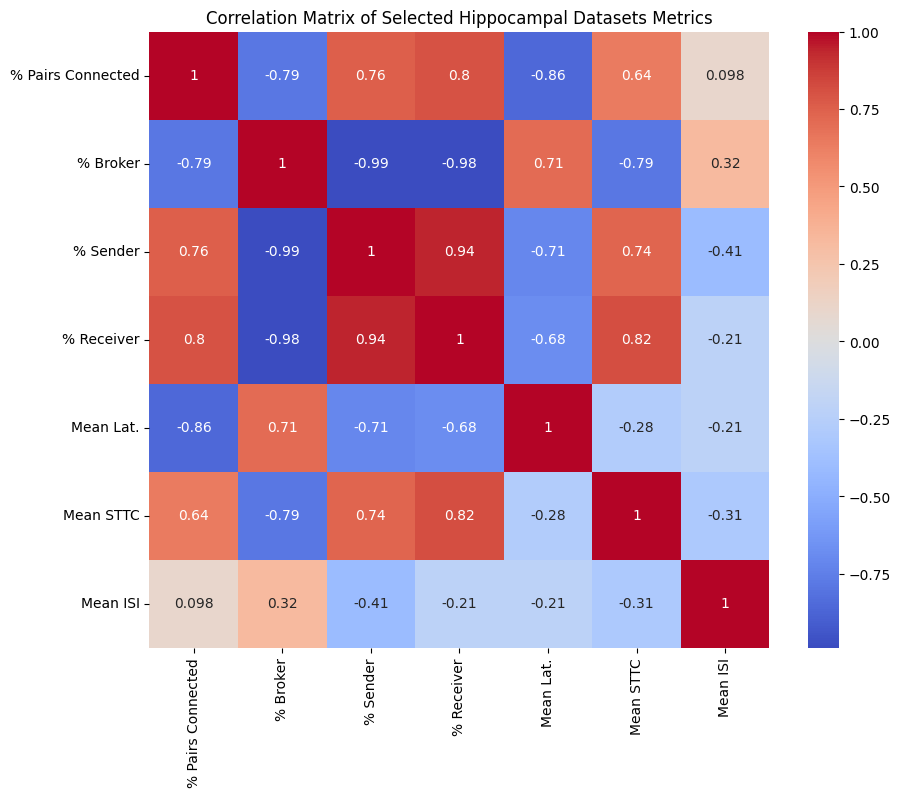

In [44]:
columns_to_include = ['% Pairs Connected', '% Broker', '% Sender', '% Receiver', 
                      'Mean Lat.', 'Mean STTC', 'Mean ISI']
df_relevant = df_combined[columns_to_include]

# Compute the correlation matrix for the selected columns
correlation_matrix_relevant = df_relevant.corr()

# Create a heatmap to visualize the correlation matrix of the selected columns
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_relevant, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Selected Hippocampal Datasets Metrics')
plt.show()